# MC866 Project 1

## PART I - Clustering Methods (The Second Algorithm)

## Clustering using Expectation–Maximization (EM) Gaussian Mixture Model (GMM)

In [26]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import matplotlib
import math
import time
import matplotlib.cm as cm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [27]:
class GMM:
    def __init__(self, n_clusters=3, random_state=None, max_iterations=1000, tolerance=1e-4):
        self.n_clusters = n_clusters
        self.rand = np.random.seed(random_state)
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.likelihoods = []
        self.means = []
        self.covs = []
        self.weights = []

    def _score(self, data):
        return np.sum(np.max(self.likelihoods, axis=1))

    def _expectation(self, data):
        for c in range(self.n_clusters):
            # check for invalid covariance matrices (if gaussian collapsed to a singularity)
            bools = self.covs[c].any(axis=1)
            if len(bools[bools == False]) > 0:
                np.fill_diagonal(self.covs[c], 1) # replace diagonal with 1

            self.likelihoods[:, c] = self.weights[c] * multivariate_normal(self.means[c], self.covs[c]).pdf(data)
            
        log_likelihood = np.sum(np.log(np.sum(self.likelihoods, axis=1)))
        # normalize likelihoods
        self.likelihoods = self.likelihoods / self.likelihoods.sum(axis=1, keepdims=1)

        return log_likelihood


    def _maximization(self, data):
        weights = self.likelihoods.sum(axis=0)
        
        # weights
        self.weights = weights / data.shape[0]

        # means
        weighted_sum = np.dot(self.likelihoods.T, data)
        self.means = weighted_sum / weights.reshape(-1, 1)

        # covariance
        for c in range(self.n_clusters):
            diff = (data - self.means[c]).T
            weighted_sum = np.dot(self.likelihoods[:, c] * diff, diff.T)
            self.covs[c] = weighted_sum / weights[c]

        return

    def aic(self, data):
        return 2*self._score(data) + 2*self.n_clusters

    def bic(self, data):
        return 2*self._score(data) + self.n_clusters*math.log(data.shape[0])

    def clusters(self, data):
        if len(self.means) == 0:
            self.means = data[np.random.choice(data.shape[0], self.n_clusters, replace = False)]
            self.weights = np.full(self.n_clusters, 1 / self.n_clusters)
            self.likelihoods = np.zeros((data.shape[0], self.n_clusters))
            self.covs = np.full((self.n_clusters, data.shape[1], data.shape[1]), np.cov(data, rowvar = False))

        data_by_cluster = []
        for c in range(self.n_clusters):
            bools = self.covs[c].any(axis=1)
            if len(bools[bools == False]) > 0:
                np.fill_diagonal(self.covs[c], 1)

            data_by_cluster = np.append(data_by_cluster, np.array(multivariate_normal(self.means[c], self.covs[c]).pdf(data)))

        data_by_cluster = data_by_cluster.reshape((self.n_clusters, data.shape[0])).T
        return np.argmax(data_by_cluster, axis=1)
    
    def fit(self, data):
        start_time = time.time()

        # initialize parameters
        self.likelihoods = np.zeros((data.shape[0], self.n_clusters))
        self.means = data[np.random.choice(data.shape[0], self.n_clusters, replace=False)]
        self.covs = np.full((self.n_clusters, data.shape[1], data.shape[1]), np.cov(data, rowvar=False))
        self.weights = np.full(self.n_clusters, 1/self.n_clusters)

        log_likelihood = 0
        converged = False
        iterations = 0
        for i in range(self.max_iterations):
            new_log_likelihood = self._expectation(data)
            self._maximization(data)

            if abs(new_log_likelihood - log_likelihood) <= self.tolerance:
                converged = True
                break
  
            log_likelihood = new_log_likelihood
            iterations += 1

        if converged:
            print(f"converged in {iterations} iterations")
        else:
            print(f"failed to converge in {iterations} iterations")

        print("--- %s seconds ---" % (time.time() - start_time))

        return

### The Dataset
First we will run tests using the provided 2d dataset, splitting it in 90% for training and 10% for test.

Afterwards we'll run the same proccess on another dataset with more dimensions.

In [28]:
df = pd.read_csv("./data/cluster.dat", sep=' ', header=None)
df.head()

msk = np.random.rand(len(df)) < 0.9 # split dataset (90% train and 10% test)

df_train = df[msk]
df_test = df[~msk]

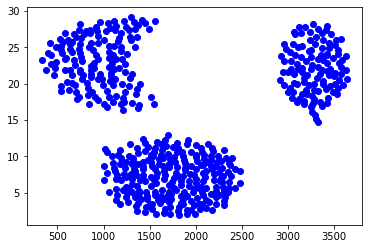

In [29]:
# 2D dataset

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="blue") # the data
plt.show()

By observing the visualization of the dataset, we can verify that 3 clusters would be adequate.

In [30]:
gmm = GMM(n_clusters=3)

We use the clusters() method to get which cluster each data point has the highest probability of belonging

In [31]:
train_data=df_train.to_numpy()
gmm.clusters(data=train_data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

The clusters are initialy initialized with random points of the dataset provided for training.

Initially without any fitting, the clusters provided are the following

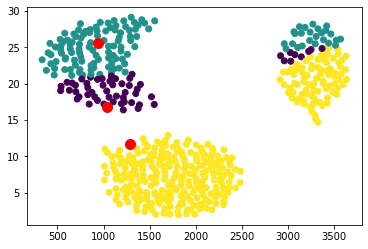

In [32]:
# initialize clusters and show their initial position in the chart

c = gmm.clusters(data=train_data)

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

In [33]:
gmm.fit(data=train_data)

converged in 11 iterations
--- 0.021622180938720703 seconds ---


### Results after fitting with the raw training data

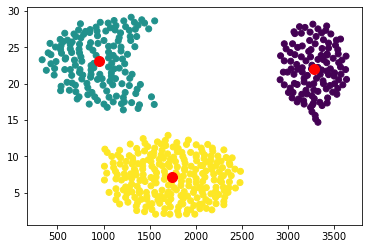

In [34]:
# Result of clusters after fitting is done

c = gmm.clusters(data=train_data)

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

As we can see, despite the fact that X and Y are on different scales, the GMM algorithm converged to optimal clusters even without a prior data normalization (unlike k-means)

## Checking the test data distribution

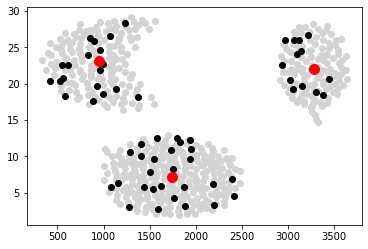

In [35]:
# the test data
fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c="black") # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()

## How the test data was classified using the prefitted gaussian mixture model

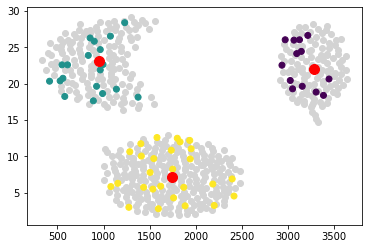

In [36]:
c = gmm.clusters(data=df_test.to_numpy())

fig, ax = plt.subplots()
ax.scatter(df_train.iloc[:,:1].values, df_train.iloc[:,1:].values, c="lightgray") # the data
ax.scatter(df_test.iloc[:,:1].values, df_test.iloc[:,1:].values, c=c) # the data
ax.scatter(gmm.means[:,:1], gmm.means[:,1:], c="red", s=100) # the mean of each cluster
plt.show()



## Metrics

### The AIC/BIC Method
We'll run the GMM algorithm with different amounts of clusters and calculate the AIC and BIC metrics for every run, where:

AIC = 2*ln(L) + p*ln(N)  
BIC = 2*ln(L) + 2*p 

We're only concerned with the diference between the two (We want the number of cluster that minimizes the diference between these metrics).

converged in 2 iterations
--- 0.0035600662231445312 seconds ---
converged in 112 iterations
--- 0.08202481269836426 seconds ---
converged in 13 iterations
--- 0.012899160385131836 seconds ---
converged in 240 iterations
--- 0.2774848937988281 seconds ---
converged in 280 iterations
--- 0.40593791007995605 seconds ---
converged in 269 iterations
--- 0.5681741237640381 seconds ---
converged in 337 iterations
--- 0.7335429191589355 seconds ---
converged in 210 iterations
--- 0.4803299903869629 seconds ---
converged in 270 iterations
--- 0.682852029800415 seconds ---


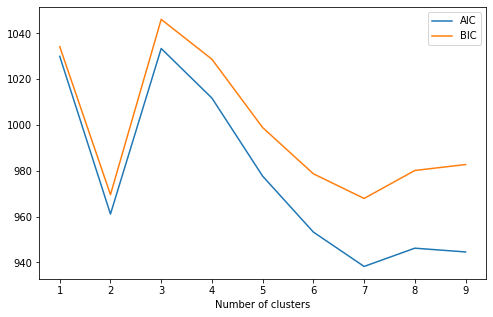

In [37]:
train_data = df_train.to_numpy()
aic_values = []
bic_values = []
cluster_range = range(1, 10)
for i in cluster_range:
    gmm = GMM(n_clusters=i)
    gmm.fit(data=train_data)
    aic_values.append(gmm.aic(data=train_data))
    bic_values.append(gmm.bic(data=train_data))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("Number of clusters")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
plt.legend(handles=[p1, p2])
plt.show()

We can verify that the difference between the AIC and BIC methods starts to increase for n_clusters > 3, so we can assume that 3 is the optimal number of clusters.

## Second problem
Now we'll tackle a problem with many more dimensions using clustering algorithms. As a proposed problem we'll attempt to solve the handwritten digits dataset using only unsupervised clustering.

We are using the skelearn digits dataset because it's an already scalled down version of the MNIST dataset, where each image has only 64 features, greatly reducing the time required to fit the models.

Since there are 10 classes in the dataset (the ten digits), an intuitive value for n_clusters would be 10, but we will validate that value using the analysis that we showed previously.

First we'll fetch the *digits* dataset from scikit, and do normalizations

Features 64
[[0.     0.     0.     ... 0.875  0.25   0.    ]
 [0.     0.     0.5625 ... 0.4375 0.     0.    ]
 [0.     0.     0.125  ... 0.6875 0.     0.    ]
 ...
 [0.     0.     0.25   ... 0.     0.     0.    ]
 [0.     0.     0.1875 ... 0.0625 0.     0.    ]
 [0.     0.     0.1875 ... 0.     0.     0.    ]]


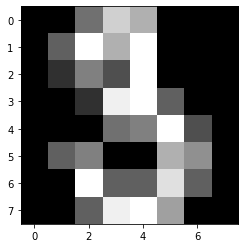

In [38]:
X, y = load_digits(return_X_y=True) # fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False) # 
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1)
# since we know that the maximum value of a pixel in the dataset is 255, we'll just divide everything by 255 for scaling.
scalling_factor = np.max(X_train)
X_train = X_train / scalling_factor
X_test = X_test / scalling_factor
print("Features", X_train.shape[1])
print(X_test)

plt.imshow(X_train[2].reshape((8,8)), cmap='gray', vmin=0, vmax=1)
plt.show()

converged in 2 iterations
--- 0.02090311050415039 seconds ---
converged in 13 iterations
--- 0.1461009979248047 seconds ---
converged in 14 iterations
--- 0.19809985160827637 seconds ---
converged in 13 iterations
--- 0.2558779716491699 seconds ---
converged in 14 iterations
--- 0.3374159336090088 seconds ---
converged in 14 iterations
--- 0.43209385871887207 seconds ---
converged in 14 iterations
--- 0.5440449714660645 seconds ---
converged in 14 iterations
--- 0.665827751159668 seconds ---
converged in 14 iterations
--- 0.6450047492980957 seconds ---
converged in 14 iterations
--- 0.7034058570861816 seconds ---
converged in 14 iterations
--- 0.9269278049468994 seconds ---
converged in 14 iterations
--- 1.0232090950012207 seconds ---
converged in 14 iterations
--- 1.0697009563446045 seconds ---
converged in 14 iterations
--- 1.0588889122009277 seconds ---
converged in 14 iterations
--- 1.062964916229248 seconds ---
converged in 14 iterations
--- 1.1399381160736084 seconds ---
converge

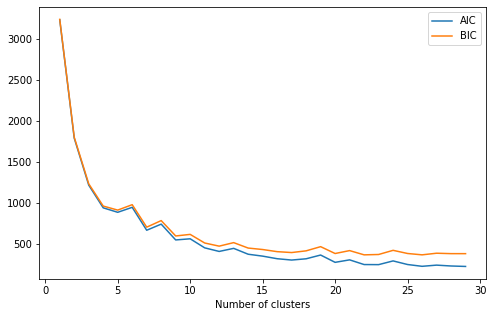

In [39]:
aic_values = []
bic_values = []
cluster_range = range(1, 30)
for i in cluster_range:
    gmm = GMM(n_clusters=i)
    gmm.fit(data=X_train)
    aic_values.append(gmm.aic(data=X_train))
    bic_values.append(gmm.bic(data=X_train))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("Number of clusters")
p1, = ax.plot(cluster_range, aic_values, label="AIC") # the data
p2, = ax.plot(cluster_range, bic_values, label="BIC") # the data
plt.legend(handles=[p1, p2])
plt.show()

From the AIC/BIC, we would assume that the optimal amount of clusters would be between 8 and 12. After testing, the best results were achieved with 12 clusters.

We'll run the clustering 30 times and consider the one with the lowest difference between AIC and BIC

In [40]:
# We'll run the method 30 times, and consider the one with the lowest difference between AIC and BIC
models = []
for i in range(30):
    gmm = GMM(n_clusters=12)
    gmm.fit(data=X_train)
    models.append(gmm)

lowest_difference = math.inf
best_gmm = None
for gmm in models:
    difference = abs(gmm.aic(data=X_train) - gmm.bic(data=X_train))
    if difference < lowest_difference:
        lowest_difference = difference
        best_gmm = gmm

print("Difference between AIC and BIC:", lowest_difference)

converged in 14 iterations
--- 0.7820818424224854 seconds ---
converged in 14 iterations
--- 0.8031148910522461 seconds ---
converged in 14 iterations
--- 0.8637819290161133 seconds ---
converged in 14 iterations
--- 0.921870231628418 seconds ---
converged in 14 iterations
--- 0.9970738887786865 seconds ---
converged in 14 iterations
--- 0.9328126907348633 seconds ---
converged in 14 iterations
--- 0.9984428882598877 seconds ---
converged in 14 iterations
--- 0.9551868438720703 seconds ---
converged in 14 iterations
--- 0.9050109386444092 seconds ---
converged in 13 iterations
--- 0.8259549140930176 seconds ---
converged in 14 iterations
--- 0.8717780113220215 seconds ---
converged in 14 iterations
--- 1.03920316696167 seconds ---
converged in 14 iterations
--- 0.9863190650939941 seconds ---
converged in 14 iterations
--- 1.026702880859375 seconds ---
converged in 14 iterations
--- 0.8631758689880371 seconds ---
converged in 14 iterations
--- 0.7875540256500244 seconds ---
converged in

Since clustering is an unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found.

We'll do that by considering the label that appears more often in the cluster being observed

In [41]:
# since clustering is a unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found
clusters = best_gmm.clusters(data=X_train)
labels_by_cluster = []
for i in range(best_gmm.means.shape[0]):
    bins = np.bincount(y_train[clusters == i])
    label_for_cluster = 0
    if bins.shape[0] > 0:
        label_for_cluster = bins.argmax() # the most common label to appear in the current cluster
    labels_by_cluster.append(label_for_cluster)
print(labels_by_cluster)

[7, 1, 3, 1, 0, 0, 6, 0, 7, 0, 0, 7]


With the labels of each cluster found, let's validate the results found using the test data.

In [42]:
clusters = best_gmm.clusters(data=X_test) 
success = 0
for i in range(y_test.shape[0]):
    if y_test[i] == labels_by_cluster[clusters[i]]:
        success += 1

print(f"Successes: {success} out of {y_test.shape[0]}")
print(f"Successes rate: {success/y_test.shape[0]}")

Successes: 59 out of 180
Successes rate: 0.3277777777777778


### Applying PCA
To allow for an easier visualization of the clustered data, we'll use PCA to decompose the data into 2 features. So we can visualize 2D scatter plots of the clustering proccess.

In [43]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
df_train_pca = pca.transform(X_train)
df_test_pca = pca.transform(X_test)

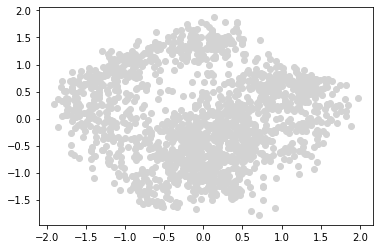

In [44]:
fig, ax = plt.subplots()
ax.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data
plt.show()

### Original Data Labeling
Let's check how the labels of the training data are distributed in the scatter

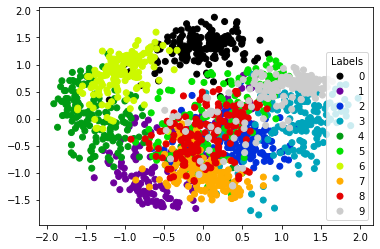

In [45]:
fig, ax = plt.subplots()
colors = cm.nipy_spectral(y_train.astype(float) / y_train.max())
for i in range(10):
    mask = y_train == i
    ax.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], c=colors[mask], label=i) # the data

ax.legend(loc="lower right", title="Labels")

plt.show()

As we can observe, for most features the data is well separated, with the exceptions of the data with labels 5 and 8 that are overlapped. So we would expect most mistakes from the model to happen with those two labels.

In [21]:
models = []
for i in range(30):
    gmm = GMM(n_clusters=12)
    gmm.fit(data=df_train_pca)
    models.append(gmm)

lowest_difference = math.inf
gmm_pca = None
for gmm in models:
    difference = abs(gmm.aic(data=df_train_pca) - gmm.bic(data=df_train_pca))
    if difference < lowest_difference:
        lowest_difference = difference
        gmm_pca = gmm

print("Difference between AIC and BIC:", lowest_difference)

failed to converge in 1000 iterations
--- 4.434922933578491 seconds ---
converged in 613 iterations
--- 2.6740782260894775 seconds ---
converged in 676 iterations
--- 3.279572010040283 seconds ---
failed to converge in 1000 iterations
--- 5.822558879852295 seconds ---
converged in 547 iterations
--- 3.339001178741455 seconds ---
converged in 431 iterations
--- 1.985598087310791 seconds ---
converged in 547 iterations
--- 2.1552319526672363 seconds ---
converged in 630 iterations
--- 2.5521280765533447 seconds ---
failed to converge in 1000 iterations
--- 4.156310081481934 seconds ---
converged in 998 iterations
--- 4.437461853027344 seconds ---
converged in 588 iterations
--- 3.063831090927124 seconds ---
converged in 678 iterations
--- 3.450472831726074 seconds ---
converged in 412 iterations
--- 2.0765011310577393 seconds ---
converged in 997 iterations
--- 5.366479873657227 seconds ---
converged in 848 iterations
--- 3.8769519329071045 seconds ---
failed to converge in 1000 iteratio

In [22]:
# since clustering is a unsupervised learning method, we'll need to check which of the labels corresponds to each cluster found
clusters = gmm_pca.clusters(data=df_train_pca)
pca_labels_by_cluster = []
for i in range(gmm_pca.means.shape[0]):
    bins = np.bincount(y_train[clusters == i])
    label_for_cluster = 0
    if bins.shape[0] > 0:
        label_for_cluster = bins.argmax() # the most common label to appear in the current cluster
    pca_labels_by_cluster.append(label_for_cluster)
print(pca_labels_by_cluster)

[6, 9, 8, 4, 1, 0, 3, 9, 2, 8, 6, 7]


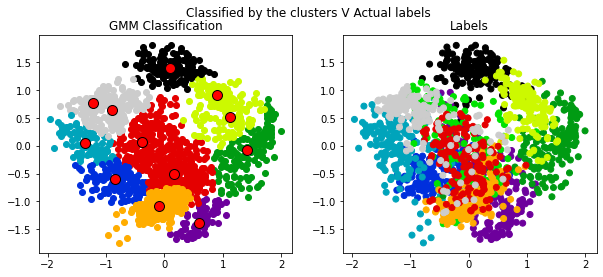

In [23]:
# Result of clusters after fitting is done

c = gmm_pca.clusters(data=df_train_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Classified by the clusters V Actual labels', fontsize=12)

for i in range(gmm_pca.means.shape[0]):
    mask = c == i
    label = pca_labels_by_cluster[i]
    color = cm.nipy_spectral(label / y_train.max())
    ax1.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], color=color) # the data

colors = cm.nipy_spectral(y_train.astype(float) / y_train.max())
for i in range(10):
    mask = y_train == i
    ax2.scatter(df_train_pca[mask][:,:1], df_train_pca[mask][:,1:], c=colors[mask]) # the data

ax1.scatter(gmm_pca.means[:,:1], gmm_pca.means[:,1:], c="red", s=100, edgecolors='k') # the data

ax1.title.set_text('GMM Classification')
ax2.title.set_text('Labels')

plt.show()

So we confirm the results found in the previous result. Even though the training is unsupervised, the difference in the images of the handwritten digits are enough that distinct clusters can be found with reasonably small overlapping.

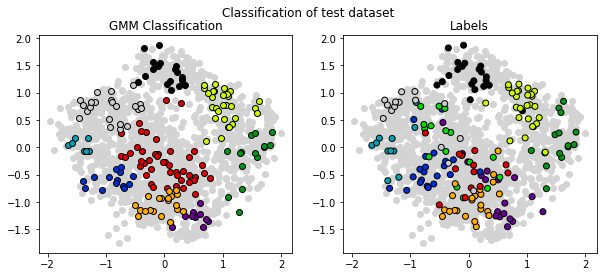

In [24]:
c = gmm_pca.clusters(data=df_test_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Classification of test dataset', fontsize=12)

ax1.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data
ax2.scatter(df_train_pca[:,:1], df_train_pca[:,1:], c="lightgray") # the data

for i in range(gmm_pca.means.shape[0]):
    mask = c == i
    label = pca_labels_by_cluster[i]
    color = cm.nipy_spectral(label / y_test.max())
    ax1.scatter(df_test_pca[mask][:,:1], df_test_pca[mask][:,1:], color=color, edgecolors='k') # the data

colors = cm.nipy_spectral(y_test.astype(float) / y_test.max())
for i in range(10):
    mask = y_test == i
    ax2.scatter(df_test_pca[mask][:,:1], df_test_pca[mask][:,1:], c=colors[mask], edgecolors='k') # the data

ax1.title.set_text('GMM Classification')
ax2.title.set_text('Labels')
plt.show()

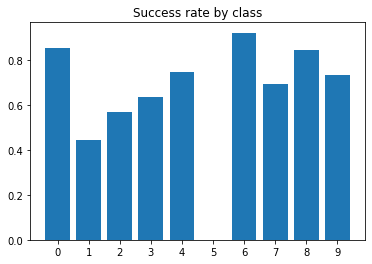

In [25]:
c = gmm_pca.clusters(data=df_test_pca)
successes = np.empty(10) 
for i in range(10):
    mask = y_test == i
    f = np.vectorize(lambda x: pca_labels_by_cluster[x])
    l = f(c[mask])
    s = np.sum(l == i)
    successes[i] = s / np.sum(mask)

fig, ax = plt.subplots()

ax.bar(range(10), successes) # the data
ax.set_xticks(np.arange(10))
ax.title.set_text('Success rate by class')
plt.show()

As expected, since the data for the labels "5" and "8" where considerably overlapped, the classification for the label "5" had by far the worst result when compared to the others.